# 7.3 Building Final Model: ML

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import r2_score
import shap

/Applications/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Applications/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks,

In [2]:
from PyTorch2Sklearn.MLP import MLP
from PyTorch2Sklearn.Transformer import Transformer
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import torch.nn as nn
from PyTorch2Sklearn.utils.data import TabularDataset, TabularDataFactory
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
import warnings
warnings.simplefilter('ignore')

## Read in and Prepare Data

In [4]:
train_data = pd.read_csv('../data/curated/modelling/train.csv')
val_data = pd.read_csv('../data/curated/modelling/val.csv')
test_data = pd.read_csv('../data/curated/modelling/test.csv')

with open('../models/feature_importance_ordering.pickle', 'rb') as f:
    feature_importance_ordering = pickle.load(f)

In [5]:
import os
from collections import defaultdict as dd
manip_type = 'NormalisedData'

csv_list = os.listdir(f'../data/curated/{manip_type}')
csv_list.sort()

# Evaluation Functions

In [6]:
def get_game_321_score(ground_truth_votes, pred_votes):
    game_321_score = 0

    if ground_truth_votes['3'] == pred_votes['3']:
        game_321_score += 3
    elif ground_truth_votes['3'] == pred_votes['2']:
        game_321_score += 2
    elif ground_truth_votes['3'] == pred_votes['1']:
        game_321_score += 1

    if ground_truth_votes['2'] == pred_votes['3']:
        game_321_score += 1
    elif ground_truth_votes['2'] == pred_votes['2']:
        game_321_score += 2
    elif ground_truth_votes['2'] == pred_votes['1']:
        game_321_score += 1

    if ground_truth_votes['1'] == pred_votes['3']:
        game_321_score += 1/3
    elif ground_truth_votes['1'] == pred_votes['2']:
        game_321_score += 2/3
    elif ground_truth_votes['1'] == pred_votes['1']:
        game_321_score += 1

    return game_321_score

In [11]:
def eval(model, year, features, random=False):

    tally = dd(int)
    game_321_score = 0
    game_count = 0

    for file in csv_list:
        if year in file:
            data = pd.read_csv(f'../data/curated/{manip_type}/{file}')

            data = data.fillna(0)

            player = data['Player']
            if random:
                pred = np.random.normal(0, 1, len(data))
            else:
                pred = model.predict(
                    data[list(list(feature_importance_ordering.keys())[features])])
            pred = pd.DataFrame(
                {'player': player, 'predicted_score': pred})

            pred_votes = {
                '3': list(pred.sort_values('predicted_score', ascending=False)['player'])[0],
                '2': list(pred.sort_values('predicted_score', ascending=False)['player'])[1],
                '1': list(pred.sort_values('predicted_score', ascending=False)['player'])[2]
            }

            tally[pred_votes['3']] += 3
            tally[pred_votes['2']] += 2
            tally[pred_votes['1']] += 1

            if sum(data['Brownlow Votes']) != 0:
                ground_truth_votes = {
                    '3': data[data['Brownlow Votes'] == 3]['Player'].values[0],
                    '2': data[data['Brownlow Votes'] == 2]['Player'].values[0],
                    '1': data[data['Brownlow Votes'] == 1]['Player'].values[0],
                }

                game_321_score += get_game_321_score(
                    ground_truth_votes, pred_votes)
                game_count += 1

    tally_list = list(tally.items())
    tally_list.sort(key=lambda x: x[1], reverse=True)

    return tally_list, game_321_score/game_count, game_321_score, game_count

# Year-by-year backtest

In [ ]:
def year_by_year_evaluation(model, features: str):
    # get year by year evaluation (train with previous years, test on next years
    
    for test_year in range(2016, 2024):

        print(f'TRAIN YEARS: 2015 - {test_year - 1}')

        train_data = pd.DataFrame()
        for file in csv_list:
            file_year = int(file.split(' ')[0])
            if file_year < test_year:
                data = pd.read_csv('../data/curated/NormalisedData/' + file)

                train_data = pd.concat([train_data, data])

        train_data = train_data.fillna(0)

        model.fit(train_data[list(
            list(feature_importance_ordering.keys())[features])], train_data['target'])

        for year in range(test_year, 2024):
            tally_list, game_321_score, game_321_score_total, game_count = eval(
                model, str(year), features)
            print(
                f'Year: {year}, Game 321 Score: {np.round(game_321_score, 2)}, Game Count: {game_count}')
            print(tally_list[:10])
            
        print('')

In [22]:
# MLP
params = {'hidden_dim': 256, 'hidden_layers': 2, 'dropout': 0, 'batch_size': 32, 'epochs': 15, 'lr': 0.0001, 'batchnorm': False, 'grad_clip': False, 'random_state': 42, 'loss': nn.MSELoss(), 'input_dim': 37, 'output_dim': 1, 'mode': 'Regression', 'verbose': True, 'TabularDataFactory': TabularDataFactory,
              'TabularDataset': TabularDataset, }
model = MLP(**params)

features = 36

year_by_year_evaluation(model, features)   

TRAIN YEARS: 2015 - 2015


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


1194
Year: 2016, Game 321 Score: 3.13, Game Count: 199
[('Patrick Dangerfield', 35), ('Lachie Neale', 32), ('Robbie Gray', 27), ('Dustin Martin', 23), ('Matthew Priddis', 22), ('Adam Treloar', 22), ('Stephen Coniglio', 20), ('Jack Steven', 19), ('Heath Shaw', 19), ('Josh P. Kennedy', 18)]
1200
Year: 2017, Game 321 Score: 3.14, Game Count: 200
[('Tom Mitchell', 36), ('Patrick Dangerfield', 34), ('Dustin Martin', 33), ('Rory Sloane', 26), ('Dayne Beams', 22), ('Dayne Zorko', 21), ('Adam Treloar', 21), ('Joshua Kelly', 21), ('Rory Laird', 19), ('Zachary Merrett', 18)]
1194
Year: 2018, Game 321 Score: 2.92, Game Count: 199
[('Tom Mitchell', 44), ('Clayton Oliver', 30), ('Jackson Macrae', 27), ('Brodie Grundy', 26), ('Jake Lloyd', 21), ('Elliot Yeo', 21), ('Rory Laird', 20), ('Patrick Cripps', 20), ('Patrick Dangerfield', 20), ('Lachie Neale', 20)]
1194
Year: 2019, Game 321 Score: 3.09, Game Count: 199
[('Nathan Fyfe', 31), ('Brodie Grundy', 29), ('Jackson Macrae', 27), ('Patrick Dangerfiel

100%|██████████| 15/15 [00:20<00:00,  1.37s/it]


1200
Year: 2017, Game 321 Score: 3.1, Game Count: 200
[('Patrick Dangerfield', 42), ('Tom Mitchell', 37), ('Dustin Martin', 31), ('Rory Sloane', 25), ('Clayton Oliver', 21), ('Dayne Beams', 21), ('Rory Laird', 20), ('Lachie Neale', 20), ('Dayne Zorko', 19), ('Adam Treloar', 19)]
1194
Year: 2018, Game 321 Score: 2.84, Game Count: 199
[('Tom Mitchell', 45), ('Brodie Grundy', 40), ('Clayton Oliver', 28), ('Jackson Macrae', 26), ('Patrick Cripps', 25), ('Lachie Neale', 24), ('Max Gawn', 22), ('Patrick Dangerfield', 21), ('Dustin Martin', 19), ('Nathan Fyfe', 19)]
1194
Year: 2019, Game 321 Score: 3.17, Game Count: 199
[('Brodie Grundy', 35), ('Nathan Fyfe', 34), ('Patrick Dangerfield', 28), ('Adam Treloar', 26), ('Lachie Neale', 25), ('Jackson Macrae', 25), ('Patrick Cripps', 22), ('Josh Dunkley', 22), ('Clayton Oliver', 21), ('Jake Lloyd', 19)]
984
Year: 2020, Game 321 Score: 2.9, Game Count: 164
[('Lachie Neale', 28), ('Zachary Merrett', 21), ('Jack Steele', 21), ('Todd Goldstein', 20), (

100%|██████████| 15/15 [00:31<00:00,  2.07s/it]


1194
Year: 2018, Game 321 Score: 2.99, Game Count: 199
[('Tom Mitchell', 44), ('Clayton Oliver', 30), ('Jackson Macrae', 27), ('Rory Laird', 24), ('Jake Lloyd', 22), ('Patrick Dangerfield', 20), ('Elliot Yeo', 20), ('Lachie Neale', 20), ('Joel Selwood', 19), ('Patrick Cripps', 19)]
1194
Year: 2019, Game 321 Score: 3.13, Game Count: 199
[('Adam Treloar', 27), ('Patrick Dangerfield', 27), ('Jake Lloyd', 26), ('Jackson Macrae', 25), ('Lachie Neale', 23), ('Patrick Cripps', 22), ('Nathan Fyfe', 22), ('Zachary Merrett', 21), ('Dustin Martin', 19), ('Josh Dunkley', 19)]
984
Year: 2020, Game 321 Score: 2.92, Game Count: 164
[('Lachie Neale', 26), ('Jake Lloyd', 23), ('Patrick Dangerfield', 23), ('Zachary Merrett', 22), ('Jack Steele', 21), ('Jackson Macrae', 21), ('Luke Parker', 19), ('Travis Boak', 18), ('Taylor Adams', 18), ('Luke Ryan', 17)]
1206
Year: 2021, Game 321 Score: 3.18, Game Count: 199
[('Tom Mitchell', 37), ('Jackson Macrae', 33), ('Clayton Oliver', 32), ('Oliver Wines', 31), ('

100%|██████████| 15/15 [00:41<00:00,  2.73s/it]


1194
Year: 2019, Game 321 Score: 3.2, Game Count: 199
[('Nathan Fyfe', 35), ('Patrick Dangerfield', 32), ('Brodie Grundy', 32), ('Adam Treloar', 27), ('Lachie Neale', 26), ('Jackson Macrae', 26), ('Patrick Cripps', 23), ('Josh Dunkley', 23), ('Travis Boak', 20), ('Zachary Merrett', 20)]
984
Year: 2020, Game 321 Score: 3.05, Game Count: 164
[('Lachie Neale', 28), ('Luke Parker', 24), ('Jack Steele', 23), ('Zachary Merrett', 22), ('Jackson Macrae', 22), ('Patrick Dangerfield', 22), ('Travis Boak', 21), ('Tom Mitchell', 19), ('Taylor Adams', 19), ('Brodie Grundy', 18)]
1206
Year: 2021, Game 321 Score: 3.16, Game Count: 199
[('Tom Mitchell', 40), ('Jack Steele', 37), ('Jackson Macrae', 35), ('Clayton Oliver', 34), ('Oliver Wines', 33), ('Touk Miller', 29), ('Darcy Parish', 28), ('Rory Laird', 26), ('Jarryd Lyons', 26), ('Marcus Bontempelli', 25)]
1206
Year: 2022, Game 321 Score: 3.06, Game Count: 200
[('Clayton Oliver', 40), ('Rory Laird', 33), ('Lachie Neale', 30), ('Andrew Brayshaw', 29)

100%|██████████| 15/15 [00:51<00:00,  3.43s/it]


984
Year: 2020, Game 321 Score: 2.9, Game Count: 164
[('Lachie Neale', 27), ('Patrick Dangerfield', 23), ('Jake Lloyd', 22), ('Zachary Merrett', 22), ('Jack Steele', 21), ('Luke Parker', 20), ('Christian Petracca', 19), ('Andrew Gaff', 18), ('Travis Boak', 16), ('Taylor Adams', 16)]
1206
Year: 2021, Game 321 Score: 3.28, Game Count: 199
[('Oliver Wines', 30), ('Tom Mitchell', 29), ('Jackson Macrae', 28), ('Clayton Oliver', 27), ('Darcy Parish', 25), ('Jarryd Lyons', 24), ('Marcus Bontempelli', 23), ('Jack Steele', 23), ('Cameron Guthrie', 23), ('Sam Walsh', 21)]
1206
Year: 2022, Game 321 Score: 3.2, Game Count: 200
[('Lachie Neale', 33), ('Christian Petracca', 29), ('Clayton Oliver', 28), ('Andrew Brayshaw', 27), ('Patrick Cripps', 20), ('Touk Miller', 19), ('Sam Walsh', 19), ('Josh Dunkley', 19), ('Rory Laird', 19), ('Darcy Parish', 18)]
1272
Year: 2023, Game 321 Score: 2.56, Game Count: 212
[('Nick Daicos', 34), ('Christian Petracca', 28), ('Zak Butters', 25), ('Andrew Brayshaw', 24)

100%|██████████| 15/15 [00:59<00:00,  3.99s/it]


1206
Year: 2021, Game 321 Score: 3.31, Game Count: 199
[('Jackson Macrae', 36), ('Tom Mitchell', 35), ('Oliver Wines', 33), ('Jarryd Lyons', 31), ('Jack Steele', 30), ('Clayton Oliver', 29), ('Sam Walsh', 26), ('Touk Miller', 25), ('Darcy Parish', 24), ('Cameron Guthrie', 24)]
1206
Year: 2022, Game 321 Score: 3.31, Game Count: 200
[('Andrew Brayshaw', 31), ('Lachie Neale', 30), ('Christian Petracca', 30), ('Clayton Oliver', 28), ('Rory Laird', 24), ('Patrick Cripps', 23), ('Touk Miller', 23), ('Callum Mills', 20), ('Zachary Merrett', 19), ('Sam Walsh', 18)]
1272
Year: 2023, Game 321 Score: 2.68, Game Count: 212
[('Christian Petracca', 34), ('Nick Daicos', 33), ('Andrew Brayshaw', 24), ('Rory Laird', 24), ('Errol Gulden', 24), ('Zak Butters', 23), ('Lachie Neale', 22), ('Tim Taranto', 22), ('Caleb Serong', 22), ('Connor Rozee', 22)]
TRAIN YEARS: 2015 - 2021


100%|██████████| 15/15 [01:10<00:00,  4.69s/it]


1206
Year: 2022, Game 321 Score: 3.14, Game Count: 200
[('Lachie Neale', 33), ('Christian Petracca', 33), ('Clayton Oliver', 28), ('Andrew Brayshaw', 27), ('Rory Laird', 23), ('Sam Walsh', 22), ('Zachary Merrett', 21), ('Callum Mills', 21), ('Patrick Cripps', 20), ('Touk Miller', 20)]
1272
Year: 2023, Game 321 Score: 2.64, Game Count: 212
[('Nick Daicos', 34), ('Christian Petracca', 33), ('Caleb Serong', 26), ('Zak Butters', 26), ('Andrew Brayshaw', 24), ('Lachie Neale', 23), ('Connor Rozee', 23), ('Tim Taranto', 21), ('Jack Sinclair', 21), ('Jordan Dawson', 21)]
TRAIN YEARS: 2015 - 2022


100%|██████████| 15/15 [01:21<00:00,  5.40s/it]


1272
Year: 2023, Game 321 Score: 2.57, Game Count: 212
[('Nick Daicos', 29), ('Christian Petracca', 27), ('Andrew Brayshaw', 26), ('Rory Laird', 24), ('Caleb Serong', 22), ('Marcus Bontempelli', 22), ('Josh Dunkley', 21), ('Tim Taranto', 21), ('Zak Butters', 21), ('Zachary Merrett', 20)]


In [21]:
# GBR
model = GradientBoostingRegressor(learning_rate=0.01,
                                      n_estimators=800,
                                      subsample=0.25,
                                      max_features=0.7,
                                      min_samples_split=64,
                                      max_depth=96,
                                      random_state=42)
featues = 36

year_by_year_evaluation(model, features)

TRAIN YEARS: 2015 - 2015
1194
Year: 2016, Game 321 Score: 2.99, Game Count: 199
[('Patrick Dangerfield', 44), ('Robbie Gray', 27), ('Scott Pendlebury', 26), ('Rory Sloane', 25), ('Adam Treloar', 25), ('Stephen Coniglio', 23), ('Dustin Martin', 23), ('Luke Parker', 21), ('Joel Selwood', 21), ('Zachary Merrett', 20)]
1200
Year: 2017, Game 321 Score: 3.11, Game Count: 200
[('Patrick Dangerfield', 36), ('Dustin Martin', 34), ('Tom Mitchell', 32), ('Rory Sloane', 31), ('Gary Ablett', 20), ('Dayne Zorko', 20), ('Joshua Kelly', 20), ('Zachary Merrett', 19), ('Adam Treloar', 19), ('Taylor Adams', 19)]
1194
Year: 2018, Game 321 Score: 2.7, Game Count: 199
[('Tom Mitchell', 38), ('Brodie Grundy', 34), ('Jackson Macrae', 29), ('Clayton Oliver', 25), ('Dayne Beams', 21), ('Patrick Dangerfield', 20), ('Nathan Fyfe', 19), ('Josh P. Kennedy', 19), ('Joel Selwood', 18), ('Stephen Coniglio', 17)]
1194
Year: 2019, Game 321 Score: 3.01, Game Count: 199
[('Patrick Dangerfield', 27), ('Nathan Fyfe', 25), (

In [20]:
# Transformer
params = {'hidden_dim': 16, 'num_transformer_layers': 1, 'num_mlp_layers': 1, 'dropout': 0, 'batch_size': 128, 'nhead': 2, 'share_embedding_mlp': False, 'use_cls': False, 'epochs': 10, 'lr': 0.0001, 'batchnorm': False, 'grad_clip': False, 'random_state': 42, 'loss': nn.MSELoss(), 'input_dim': 37, 'output_dim': 1, 'mode': 'Regression', 'verbose': True, 'TabularDataFactory': TabularDataFactory,
              'TabularDataset': TabularDataset, }

model = Transformer(**params)
features = 36

year_by_year_evaluation(model, features)    

TRAIN YEARS: 2015 - 2015


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


1194
Year: 2016, Game 321 Score: 2.71, Game Count: 199
[('Patrick Dangerfield', 34), ('Robbie Gray', 28), ('Scott Pendlebury', 28), ('Luke Parker', 24), ('Marcus Bontempelli', 22), ('Rory Sloane', 21), ('Zachary Merrett', 21), ('Bryce Gibbs', 20), ('Stephen Coniglio', 20), ('Adam Treloar', 18)]
1200
Year: 2017, Game 321 Score: 2.84, Game Count: 200
[('Dustin Martin', 35), ('Patrick Dangerfield', 35), ('Rory Sloane', 30), ('Dayne Zorko', 28), ('Tom Mitchell', 26), ('Joshua Kelly', 23), ('Dayne Beams', 21), ('Nathan Fyfe', 20), ('Dyson Heppell', 19), ('Gary Ablett', 18)]
1194
Year: 2018, Game 321 Score: 2.5, Game Count: 199
[('Tom Mitchell', 34), ('Patrick Dangerfield', 29), ('Jackson Macrae', 25), ('Stephen Coniglio', 24), ('Clayton Oliver', 24), ('Dayne Beams', 19), ('Elliot Yeo', 19), ('Joel Selwood', 17), ('Brodie Grundy', 17), ('Steele Sidebottom', 16)]
1194
Year: 2019, Game 321 Score: 2.73, Game Count: 199
[('Patrick Dangerfield', 36), ('Nathan Fyfe', 31), ('Zachary Merrett', 22), 

100%|██████████| 10/10 [00:54<00:00,  5.49s/it]


1200
Year: 2017, Game 321 Score: 2.9, Game Count: 200
[('Patrick Dangerfield', 37), ('Dustin Martin', 33), ('Rory Sloane', 30), ('Dayne Zorko', 23), ('Joshua Kelly', 22), ('Tom Mitchell', 22), ('Dayne Beams', 20), ('Zachary Merrett', 19), ('Gary Ablett', 19), ('Taylor Adams', 19)]
1194
Year: 2018, Game 321 Score: 2.58, Game Count: 199
[('Tom Mitchell', 34), ('Patrick Dangerfield', 26), ('Brodie Grundy', 26), ('Jackson Macrae', 25), ('Clayton Oliver', 23), ('Dayne Beams', 18), ('Nathan Fyfe', 18), ('Andrew Gaff', 18), ('Stephen Coniglio', 17), ('Joel Selwood', 17)]
1194
Year: 2019, Game 321 Score: 2.9, Game Count: 199
[('Nathan Fyfe', 30), ('Patrick Dangerfield', 29), ('Brodie Grundy', 27), ('Adam Treloar', 22), ('Dayne Zorko', 21), ('Patrick Cripps', 21), ('Lachie Neale', 20), ('Jackson Macrae', 20), ('Joshua Kelly', 20), ('Jarryd Lyons', 20)]
984
Year: 2020, Game 321 Score: 2.62, Game Count: 164
[('Lachie Neale', 26), ('Luke Parker', 23), ('Jack Steele', 23), ('Patrick Dangerfield', 2

100%|██████████| 10/10 [01:21<00:00,  8.14s/it]


1194
Year: 2018, Game 321 Score: 2.61, Game Count: 199
[('Tom Mitchell', 37), ('Brodie Grundy', 33), ('Clayton Oliver', 27), ('Patrick Dangerfield', 24), ('Jackson Macrae', 22), ('Dayne Beams', 19), ('Nathan Fyfe', 18), ('Stephen Coniglio', 17), ('Max Gawn', 17), ('Andrew Gaff', 17)]
1194
Year: 2019, Game 321 Score: 2.94, Game Count: 199
[('Brodie Grundy', 32), ('Nathan Fyfe', 29), ('Lachie Neale', 25), ('Patrick Dangerfield', 25), ('Jackson Macrae', 24), ('Adam Treloar', 23), ('Dayne Zorko', 20), ('Patrick Cripps', 20), ('Max Gawn', 19), ('Jarryd Lyons', 19)]
984
Year: 2020, Game 321 Score: 2.72, Game Count: 164
[('Lachie Neale', 27), ('Luke Parker', 24), ('Jack Steele', 23), ('Brodie Grundy', 21), ('Todd Goldstein', 20), ('Max Gawn', 20), ('Jackson Macrae', 19), ('Andrew Gaff', 16), ('Christian Petracca', 15), ('Patrick Dangerfield', 15)]
1206
Year: 2021, Game 321 Score: 2.94, Game Count: 199
[('Jack Steele', 34), ('Max Gawn', 29), ('Touk Miller', 29), ('Oliver Wines', 28), ('Marcus 

100%|██████████| 10/10 [01:48<00:00, 10.84s/it]


1194
Year: 2019, Game 321 Score: 2.97, Game Count: 199
[('Brodie Grundy', 35), ('Nathan Fyfe', 27), ('Patrick Dangerfield', 27), ('Lachie Neale', 26), ('Adam Treloar', 26), ('Jackson Macrae', 24), ('Max Gawn', 20), ('Dayne Zorko', 19), ('Josh Dunkley', 19), ('Jarryd Lyons', 19)]
984
Year: 2020, Game 321 Score: 2.8, Game Count: 164
[('Lachie Neale', 31), ('Luke Parker', 24), ('Jack Steele', 23), ('Max Gawn', 23), ('Brodie Grundy', 22), ('Todd Goldstein', 21), ('Jackson Macrae', 19), ('Andrew Gaff', 16), ('Dylan Shiel', 15), ('Sam Menegola', 15)]
1206
Year: 2021, Game 321 Score: 3.0, Game Count: 199
[('Jack Steele', 31), ('Oliver Wines', 30), ('Max Gawn', 28), ('Touk Miller', 28), ('Jackson Macrae', 27), ('Marcus Bontempelli', 26), ('Jarryd Lyons', 24), ('Brodie Grundy', 24), ('Darcy Parish', 23), ('Tom Mitchell', 22)]
1206
Year: 2022, Game 321 Score: 2.77, Game Count: 200
[('Clayton Oliver', 29), ('Lachie Neale', 26), ('Touk Miller', 26), ('Christian Petracca', 25), ('Zachary Merrett', 

100%|██████████| 10/10 [02:19<00:00, 13.92s/it]


984
Year: 2020, Game 321 Score: 2.68, Game Count: 164
[('Lachie Neale', 26), ('Max Gawn', 26), ('Brodie Grundy', 23), ('Todd Goldstein', 21), ('Jack Steele', 20), ('Luke Parker', 19), ('Jackson Macrae', 19), ('Andrew Gaff', 17), ('Dylan Shiel', 15), ('Sam Menegola', 15)]
1206
Year: 2021, Game 321 Score: 2.82, Game Count: 199
[('Max Gawn', 32), ('Jack Steele', 31), ('Brodie Grundy', 27), ('Oliver Wines', 27), ('Touk Miller', 26), ('Jackson Macrae', 25), ('Jarryd Lyons', 25), ('Marcus Bontempelli', 25), ('Tom Mitchell', 24), ('Darcy Parish', 21)]
1206
Year: 2022, Game 321 Score: 2.76, Game Count: 200
[('Touk Miller', 26), ('Andrew Brayshaw', 24), ('Lachie Neale', 24), ('Christian Petracca', 24), ('Clayton Oliver', 24), ('Rory Laird', 24), ('Zachary Merrett', 22), ('James Sicily', 21), ('Josh Dunkley', 21), ('Callum Mills', 21)]
1272
Year: 2023, Game 321 Score: 2.24, Game Count: 212
[('Rowan Marshall', 29), ('Marcus Bontempelli', 28), ('Andrew Brayshaw', 24), ('Jordan Dawson', 24), ('Timo

100%|██████████| 10/10 [02:36<00:00, 15.69s/it]


1206
Year: 2021, Game 321 Score: 2.95, Game Count: 199
[('Jack Steele', 31), ('Oliver Wines', 30), ('Max Gawn', 29), ('Brodie Grundy', 28), ('Jackson Macrae', 26), ('Marcus Bontempelli', 26), ('Touk Miller', 25), ('Jarryd Lyons', 24), ('Darcy Parish', 24), ('Tom Mitchell', 21)]
1206
Year: 2022, Game 321 Score: 2.86, Game Count: 200
[('Clayton Oliver', 28), ('Rory Laird', 25), ('Lachie Neale', 24), ('Christian Petracca', 24), ('Touk Miller', 24), ('Andrew Brayshaw', 22), ('Zachary Merrett', 22), ('James Sicily', 21), ('Callum Mills', 21), ('Patrick Cripps', 19)]
1272
Year: 2023, Game 321 Score: 2.36, Game Count: 212
[('Rowan Marshall', 29), ('Marcus Bontempelli', 28), ('Andrew Brayshaw', 24), ('Thomas Stewart', 24), ('Nick Daicos', 23), ('Timothy English', 23), ('Rory Laird', 23), ('Jordan Dawson', 23), ('Noah Anderson', 22), ('Zachary Merrett', 21)]
TRAIN YEARS: 2015 - 2021


100%|██████████| 10/10 [03:06<00:00, 18.68s/it]


1206
Year: 2022, Game 321 Score: 2.84, Game Count: 200
[('Lachie Neale', 29), ('Clayton Oliver', 28), ('Rory Laird', 27), ('Christian Petracca', 25), ('Touk Miller', 24), ('Andrew Brayshaw', 20), ('James Sicily', 20), ('Zachary Merrett', 20), ('Callum Mills', 20), ('Patrick Cripps', 19)]
1272
Year: 2023, Game 321 Score: 2.38, Game Count: 212
[('Rowan Marshall', 28), ('Marcus Bontempelli', 27), ('Nick Daicos', 24), ('Andrew Brayshaw', 24), ('Rory Laird', 24), ('Zak Butters', 23), ('Jordan Dawson', 23), ('Thomas Stewart', 23), ('Timothy English', 22), ('Tim Taranto', 21)]
TRAIN YEARS: 2015 - 2022


100%|██████████| 10/10 [03:44<00:00, 22.49s/it]


1272
Year: 2023, Game 321 Score: 2.42, Game Count: 212
[('Rowan Marshall', 27), ('Marcus Bontempelli', 27), ('Andrew Brayshaw', 25), ('Thomas Stewart', 25), ('Zak Butters', 24), ('Nick Daicos', 23), ('Tim Taranto', 23), ('Rory Laird', 23), ('Christian Petracca', 23), ('Jordan Dawson', 22)]


In [7]:
# XGB
model = XGBRegressor(**{
        'random_state': 19260817,
        'n_jobs': -1,
        'n_estimators': 400, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.55, 'gamma': 1e-06, 'eta': 0.1
    })

features = 19

year_by_year_evaluation(model, features)

TRAIN YEARS: 2015 - 2015
Year: 2016, Game 321 Score: 2.73, Game Count: 199
[('Patrick Dangerfield', 48), ('Robbie Gray', 26), ('Scott Pendlebury', 25), ('Dustin Martin', 24), ('Joel Selwood', 23), ('Zachary Merrett', 22), ('Adam Treloar', 20), ('Lachie Neale', 20), ('Bryce Gibbs', 19), ('Luke Parker', 19)]
Year: 2017, Game 321 Score: 2.73, Game Count: 200
[('Patrick Dangerfield', 35), ('Dustin Martin', 33), ('Rory Sloane', 28), ('Tom Mitchell', 27), ('Dayne Zorko', 24), ('Gary Ablett', 20), ('Joshua Kelly', 20), ('Matt Crouch', 19), ('Zachary Merrett', 19), ('Taylor Adams', 19)]
Year: 2018, Game 321 Score: 2.57, Game Count: 199
[('Tom Mitchell', 40), ('Clayton Oliver', 33), ('Brodie Grundy', 31), ('Jackson Macrae', 28), ('Nathan Fyfe', 22), ('Patrick Dangerfield', 22), ('Dayne Beams', 20), ('Lachie Neale', 19), ('Elliot Yeo', 18), ('Stephen Coniglio', 16)]
Year: 2019, Game 321 Score: 2.76, Game Count: 199
[('Patrick Dangerfield', 32), ('Nathan Fyfe', 28), ('Patrick Cripps', 26), ('Jack

In [25]:
# Linear Regression
model = LinearRegression(**{'fit_intercept': True,
                                })
features = 36

year_by_year_evaluation(model, features)

TRAIN YEARS: 2015 - 2015
1194
Year: 2016, Game 321 Score: 2.94, Game Count: 199
[('Patrick Dangerfield', 36), ('Robbie Gray', 27), ('Scott Pendlebury', 26), ('Dustin Martin', 25), ('Lachie Neale', 25), ('Luke Shuey', 21), ('Rory Sloane', 20), ('Stephen Coniglio', 20), ('Adam Treloar', 20), ('Luke Parker', 19)]
1200
Year: 2017, Game 321 Score: 2.94, Game Count: 200
[('Patrick Dangerfield', 38), ('Dustin Martin', 37), ('Rory Sloane', 31), ('Tom Mitchell', 28), ('Joshua Kelly', 23), ('Dayne Zorko', 20), ('Dayne Beams', 20), ('Zachary Merrett', 19), ('Clayton Oliver', 19), ('Gary Ablett', 18)]
1194
Year: 2018, Game 321 Score: 2.62, Game Count: 199
[('Tom Mitchell', 38), ('Brodie Grundy', 35), ('Clayton Oliver', 30), ('Nathan Fyfe', 24), ('Jackson Macrae', 24), ('Patrick Dangerfield', 20), ('Dayne Beams', 19), ('Max Gawn', 18), ('Sebastian Ross', 17), ('Rory Laird', 16)]
1194
Year: 2019, Game 321 Score: 2.95, Game Count: 199
[('Adam Treloar', 29), ('Nathan Fyfe', 29), ('Brodie Grundy', 29),

In [14]:
# Random Baseline

for year in range(2016, 2024):
    tally_list, game_321_score, game_321_score_total, game_count = eval(
        None, str(year), None, random=True)
    print(
        f'Year: {year}, Game 321 Score: {np.round(game_321_score, 2)}, Game Count: {game_count}')
    print(tally_list[:10])

Year: 2016, Game 321 Score: 0.3, Game Count: 199
[('Shaun Grigg', 11), ('Travis Boak', 10), ('Lachlan Hunter', 10), ('Ben McEvoy', 9), ('Tom Lynch', 9), ('Ryan Bastinac', 9), ('Zach Tuohy', 8), ('Brandon Matera', 8), ('Rory Laird', 8), ('Danyle Pearce', 8)]
Year: 2017, Game 321 Score: 0.28, Game Count: 200
[('Billy Longer', 14), ('David Astbury', 11), ('Jared Polec', 11), ('Jack Sinclair', 10), ('Tom McDonald', 9), ('Patrick Dangerfield', 9), ('Blake Acres', 9), ('Matthew Rosa', 8), ('Sam Gibson', 8), ('Jack Steele', 8)]
Year: 2018, Game 321 Score: 0.31, Game Count: 199
[('Harry Cunningham', 11), ('James Frawley', 10), ('Paul Seedsman', 9), ('Shaun Atley', 9), ('Scott Pendlebury', 9), ('Jack Graham', 8), ('Tom Lynch', 8), ('Jack Billings', 8), ('Alex Pearce', 8), ('Max Gawn', 8)]
Year: 2019, Game 321 Score: 0.24, Game Count: 199
[('Karl Amon', 14), ('Kane Lambert', 12), ('Jacob Hopper', 11), ('Jarrod Harbrow', 11), ('Brayden Fiorini', 10), ('Brodie Smith', 10), ('Matthew De Boer', 9), 

## Train Models

### Fixed MLP (replicate tuning)

In [ ]:
params = {'hidden_dim': 256, 'hidden_layers': 2, 'dropout': 0, 'batch_size': 32, 'epochs': 15, 'lr': 0.0001, 'batchnorm': False, 'grad_clip': False, 'random_state': 42, 'loss': nn.MSELoss(), 'input_dim': 37, 'output_dim': 1, 'mode': 'Regression', 'verbose': True, 'TabularDataFactory': TabularDataFactory,
          'TabularDataset': TabularDataset, }

fixed_mlp = MLP(**params)
fixed_mlp.fit(train_data[list(list(feature_importance_ordering.keys())[
    36])], train_data['target'])

In [9]:
mlp_pred = fixed_mlp.predict(train_data[list(list(feature_importance_ordering.keys())[
    36])])
r2_score(train_data['target'], mlp_pred)

0.9092463304640118

In [10]:
with open('../models/final_models/fixed_mlp.pickle', 'wb') as f:
    pickle.dump(fixed_mlp, f)

### Continuously Retrained MLP

In [11]:
params = {'hidden_dim': 256, 'hidden_layers': 2, 'dropout': 0, 'batch_size': 32, 'epochs': 15, 'lr': 0.0001, 'batchnorm': False, 'grad_clip': False, 'random_state': 42, 'loss': nn.MSELoss(), 'input_dim': 37, 'output_dim': 1, 'mode': 'Regression', 'verbose': True, 'TabularDataFactory': TabularDataFactory,
          'TabularDataset': TabularDataset, }

THIS_YEAR = 2024
up_to_date_train_data = pd.DataFrame()
for file in csv_list:
    file_year = int(file.split(' ')[0])
    if file_year < THIS_YEAR:
        data = pd.read_csv('../data/curated/NormalisedData/' + file)

        up_to_date_train_data = pd.concat([up_to_date_train_data, data])

up_to_date_train_data = up_to_date_train_data.fillna(0)

retrain_mlp = MLP(**params)
retrain_mlp.fit(up_to_date_train_data[list(list(feature_importance_ordering.keys())[
    36])], up_to_date_train_data['target'])

100%|██████████| 15/15 [01:45<00:00,  7.05s/it]


In [12]:
with open('../models/final_models/retrain_mlp.pickle', 'wb') as f:
    pickle.dump(retrain_mlp, f)

# SHAP

In [6]:
with open('../models/final_models/fixed_mlp.pickle', 'rb') as f:
    fixed_mlp = pickle.load(f)

  0%|          | 0/100 [00:00<?, ?it/s]

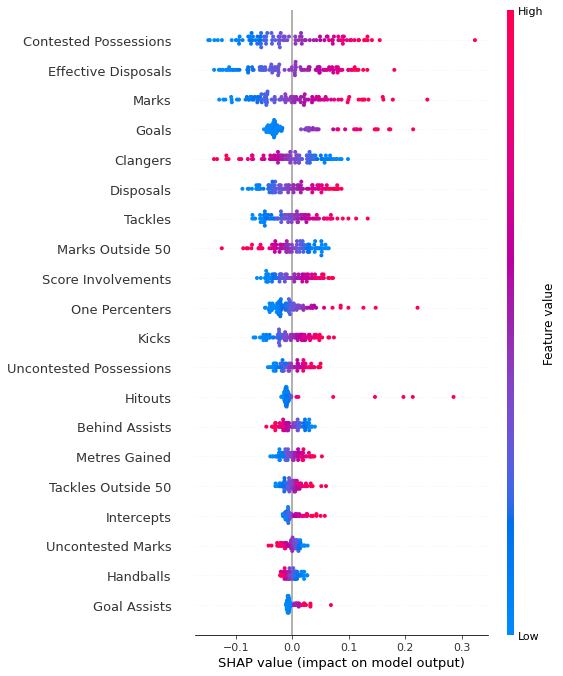

In [12]:
background_data = test_data.sample(n=100, random_state=0)

explainer = shap.KernelExplainer(
    fixed_mlp.predict, background_data[list(list(feature_importance_ordering.keys())[36])])

shap_values = explainer.shap_values(
    background_data[list(list(feature_importance_ordering.keys())[36])])

# Visualization
shap.summary_plot(shap_values, background_data[list(
    list(feature_importance_ordering.keys())[36])])

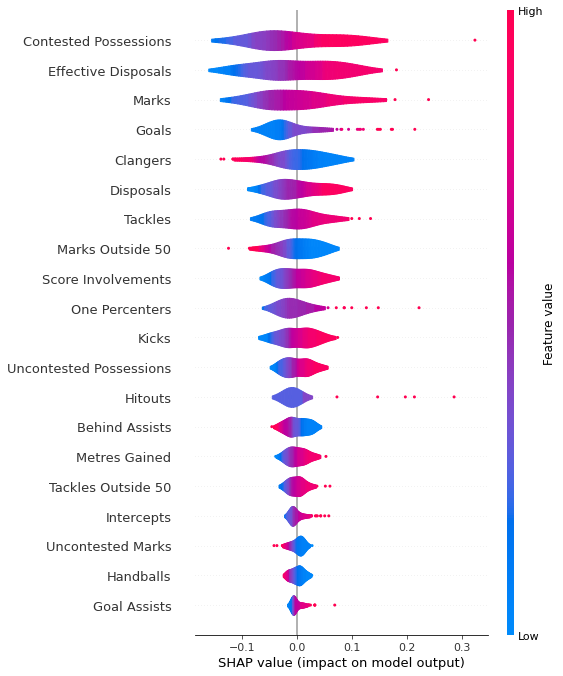

In [40]:
shap.summary_plot(shap_values, background_data[list(
    list(feature_importance_ordering.keys())[36])], plot_type='violin')

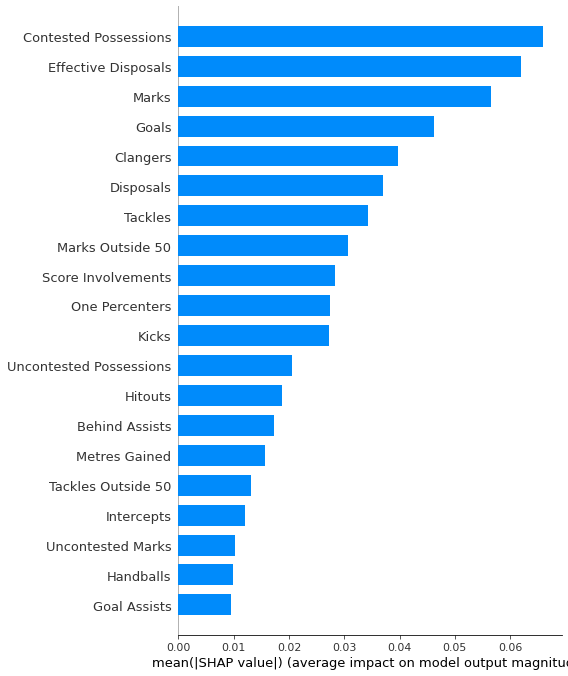

In [37]:
shap.summary_plot(shap_values, background_data[list(
    list(feature_importance_ordering.keys())[36])], plot_type='bar')

In [7]:
background_data = test_data.sample(n=250, random_state=0)

explainer = shap.KernelExplainer(
    fixed_mlp.predict, background_data[list(list(feature_importance_ordering.keys())[36])])

shap_values = explainer.shap_values(
    background_data[list(list(feature_importance_ordering.keys())[36])])

# Visualization
shap.summary_plot(shap_values, background_data[list(
    list(feature_importance_ordering.keys())[36])])

Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/250 [00:00<?, ?it/s]

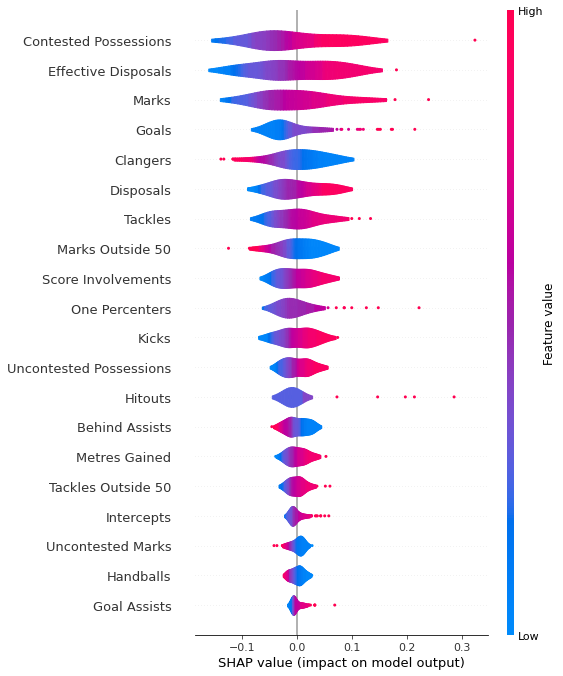

In [ ]:
shap.summary_plot(shap_values, background_data[list(
    list(feature_importance_ordering.keys())[36])], plot_type='violin')

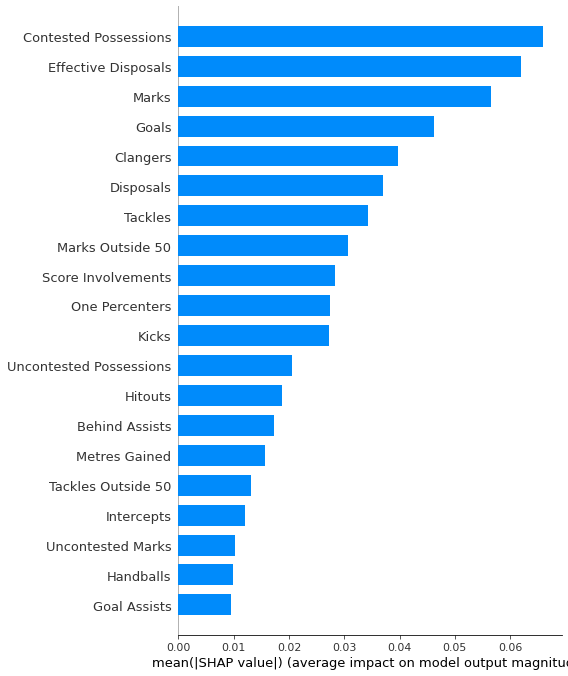

In [ ]:
shap.summary_plot(shap_values, background_data[list(
    list(feature_importance_ordering.keys())[36])], plot_type='bar')